# Predictive modeling and Supervised learning


### Basic idea: each observation is made of a vector $x \in \cal X$ (for example $x \in \mathbb R^p$) and a scalar $y$

### Our goal is to build a model of the relationship between $x$ and $y$: $y \approx f(x)$. 

### $x$: predictors, regressors, features, exogenous variables<br>$y$: response, dependent variable, endogenous variable 



### Two distinct goals for this: <br><br> 1. Prediction: in the future we will get $x$ and have to *predict* $\hat{y} = f(x).$<br><br> 2. Inference/understanding/model selection: Understanding the nature of the dependence between $x$ and $y$: 
- Which variables in $x$ are important for explaining or predicting $y$?
- What type of dependence does $y$ have on $x$: linear? more complex?  
    
### Regression: $y\in \mathbb R$ numeric<br>Classification: $y \in \cal G$ an *unordered* set 

# eBay shirts: a classification problem

### $x \in \mathbb R^{K\times K \times 3}$ : the image itself <br> $y \in \{\mbox{girl's},\mbox{boy's}\}$

### More involved example: [Cifar-10](https://www.cs.toronto.edu/~kriz/cifar.html) with 10 classes

### A good model: $f(x)$ such that $f(x)\approx 1$ for girls and $f(x)\approx 0$ for boys

### Possible $f$: the average red value for all pixels<br> Does not do a very good job in separating girls from boys...

# Netflix movies: a regression problem (sort of)

### Recall we had $x \in \mathbb R^{99}$ movies, plus one special (Miss Congeniality) that we will call $y$

### All $x$ values are not really in $\mathbb R$ but in $\{0=None,1,2,3,4,5\}$<br>$y$ is in $\{1,2,3,4,5\}$ (no missing)

### A good model $f(x)$ sees the scores a user gave to the $99$ movies (including which are missing) and gives a value that is close to $y$ for the same user

# Some more examples from real life

### Genome-Wide Association Studies (GWAS): find genetic causes of disease:
* $y \in \{sick, healthy\}$ for specific disease
* $x \in \{0,1,2\}^{1M}$ ($p=10^6$) number of copies of "risk" variant in each location in the genome
* The goal is to understand which coordinates in $x$ are related to $y$, and predict risk of $y$ for new people
    
### Email spam detection:
* $y \in \{OK, spam\}$ for each email
* $x$ can include sender identity, words and terms ("prize!", "sex",...)
* The model should identify and remove spam

### Online advertising: 
* Surfer arrives on website, need to decide if and what add to show them
* $y$ can be the amount she will spend if shown advertising for shirt/shoes/car/home 
* $x$: surfing history, location, time of day/week/year, information from other databases,...

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.stats import pearsonr
import warnings
import math
import random
from sklearn.decomposition import PCA

%matplotlib inline


ratings = pd.read_table("http://www.tau.ac.il/~saharon/StatsLearn2018/train_ratings_all.dat", header = None)
ratings[ratings == 0] = None
miss_cong = pd.read_csv("http://www.tau.ac.il/~saharon/StatsLearn2018/train_y_rating.dat", header = None, names = ['score'])
movies = pd.read_csv("http://www.tau.ac.il/~saharon/StatsLearn2018/movie_titles.txt", header = None, names = ['year', 'title'])

def scatter_cong(mov1):
    mov1_id = movies.index[movies['title'] == mov1][0]
    mov1_scores = ratings.values[:, mov1_id]
    mov2_scores = miss_cong.values[:,0]
    nas = np.isnan(mov1_scores)
    agg_data = pd.DataFrame({'mov1': mov1_scores[~nas], 'mov2': mov2_scores[~nas]}).groupby(['mov1', 'mov2']).size().reset_index()
    agg_data.columns = [mov1, 'Miss Congeniality', 'count']
    cc = agg_data['count']
    sns.lmplot(mov1, 'Miss Congeniality', scatter_kws={'s' : cc}, data = agg_data, legend = False, fit_reg=False, ci=None)
    plt.title('Corr %f' %np.corrcoef(ratings.values[:, mov1_id],miss_cong.values[:,0])[0,1])
    plt.show()

# Some simple models for Netflix

### The same score as a similar movie, say Sweet Home Alabama


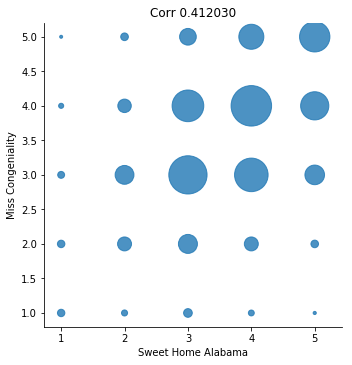

In [3]:

scatter_cong ('Sweet Home Alabama')


### The first PC score (those who love everything, love Miss Congeniality?)

Text(0.5, 1.0, 'Corr -0.467984')

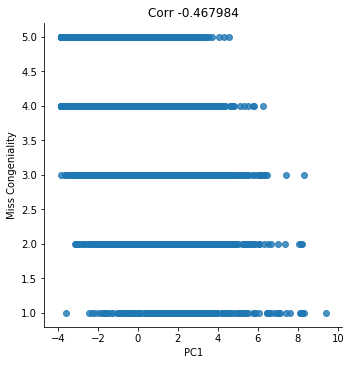

In [4]:
X = ratings.values[:,:14]
X_centered = X - X.mean(axis = 0)
pca = PCA()
pca.fit(X_centered)
W = pca.components_
T = np.matmul(X_centered, W.T)
add_data_1=pd.DataFrame({'PC1': T[:,0], 'Miss Congeniality':miss_cong.values[:,0]})
sns.lmplot('PC1', 'Miss Congeniality', data=add_data_1, legend = False, fit_reg=False, ci=None)
plt.title('Corr %f' %np.corrcoef(T[:,0],miss_cong.values[:,0])[0,1])

# Predictive modeling paradigm

### We typically assume that we have a *training* dataset of size $n$: $Tr = \{(x_1,y_1),...,(x_n,y_n)\} = (X_{n\times p},Y_{n\times 1}).$
### IID assumption: each pair $(x_i,y_i)$ is drawn indepednently from some distribution $P_{x,y}$. 
### A modeling approach takes $Tr$ as input and outputs a *prediction model* $\hat{f}(x)$ based on the training data<br>In prediction: we get a new value $x_0$ and predict $\hat{y}_0 = \hat{f}(x_0)$. 
### How good is our prediction? We typically define a loss function $L(y,\hat{y})$ and the quality of the model is $\mathbb E_{x_0,y_0}(L(y_0, \hat{y}_0))$

# The loss function $L$

### It measures the quality of the prediction: we can think of $L(y,\hat{y})$ as a measure of how much we lose when we predict $\hat{y}$ but the truth is $y$.

### Simple example for classification: *misclassification error loss*
$$ L(y,\hat{y}) = \left\{\begin{array}{ll} 0 & \mbox{if } y=\hat{y}\\ 
1 & \mbox{if } y\neq\hat{y}\end{array} \right.$$

### More complex approach: penalize different types of error differently, e.g.: 
$$ L(y,\hat{y}) = \left\{\begin{array}{ll} 0 & \mbox{if } y=\hat{y}\\ 
1 & \mbox{if } y=0,\hat{y}=1\\
10 & \mbox{if } y=1,\hat{y}=0 \end{array} \right.$$


### Simple example for regression: *squared error loss*
$$ L(y,\hat{y}) = (y-\hat{y})^2.$$


# Evaluating predictive models

### We are interested in $\mathbb E_{x_0,y_0}(L(y_0, \hat{y}_0))$, but we don't know it

### Solution: in addition to the training data $Tr$, have a *test* data $Te= \{(x_{n+1},y_{n+1}),...,(x_{n+m},y_{n+m})\}$ of size $m$ and evaluate the model on it: $\;\;\hat{Err} = \frac{1}{m} \sum_{i=n+1}^{n+m} L(y_i, \hat{f}(x_i)).$

### For squared error loss, it is typical to report the *Root* mean squared error: 
$$RMSE = \sqrt{\frac{1}{m} \sum_{i=n+1}^{n+m} (y_i-\hat{f}(x_i))^2}.$$

### Since we typically only have one dataset (as in Netflix, eBay examples), we split it *randomly* in two parts:
* Training set (typically $80\%$ of the data)
* Test set (typically $20\%$ of the data)

## Let's divide our Netflix data 80-20:

In [5]:
X = ratings.values
Y = miss_cong.values[:,0]
n = X.shape[0]
tr_size = math.floor(0.8*n)
te_size = n-tr_size
tr_ind = random.sample(range(n),tr_size)
Xtr = X[tr_ind,]
Xte = np.delete(X,tr_ind,0)
Ytr = Y[tr_ind]
Yte = np.delete(Y,tr_ind)

print(n,Xtr.shape, Xte.shape, Ytr.shape, Yte.shape)

10000 (8000, 99) (2000, 99) (8000,) (2000,)


# Linear Regression

### Assume now $x \in \mathbb R^p, y\in \mathbb R$, and we want to build a model of the form:
$$ \hat{f}(x) = \hat{\beta}_0 + \hat{\beta}_1 x_1 + \ldots + \hat{\beta}_p x_p.$$

### We have $Tr$, how can we estimate the coefficients?

### Find coefficients that ''fit" $Tr$ well, that is $\hat{f}(x_i) \approx y_i,\;i=1,\ldots,n.$

### Possible approach: Minmize *residual sum of squares* (RSS):
$$ RSS(\beta_0,\beta_1,...,\beta_p) = \sum_{i=1}^n (y_i - (\hat{\beta}_0 + \hat{\beta}_1 x_{i1} + \ldots + \hat{\beta}_p x_{ip}))^2 = \|Y - X_{n\times (p+1)} \beta\|^2.$$

### This is the *ordinary least squares (OLS) linear regression* problem



# Simple Demonstration: $p=1$ on Netflix Data
Let's go back to y = Miss Congeniality vs x = Sweet Home Alabama: 

In [9]:
mov1_id = movies.index[movies['title'] == 'Sweet Home Alabama'][0]
mov1_scores = Xtr[:, mov1_id]
mov2_scores = Ytr
import statsmodels.api as sm
mov1_scores_X = sm.add_constant(mov1_scores)
model = sm.OLS(mov2_scores,mov1_scores_X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     1643.
Date:                Tue, 30 Apr 2019   Prob (F-statistic):               0.00
Time:                        12:30:50   Log-Likelihood:                -10262.
No. Observations:                8000   AIC:                         2.053e+04
Df Residuals:                    7998   BIC:                         2.054e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1150      0.038     55.370      0.0

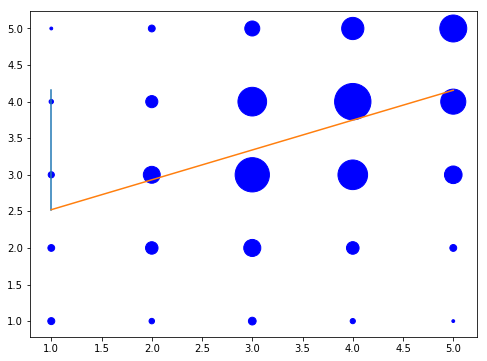

In [10]:
agg_data = pd.DataFrame({'mov1': mov1_scores, 'mov2': mov2_scores}).groupby(['mov1', 'mov2']).size().reset_index()
agg_data.columns = ['Sweet Home Alabama', 'Miss Congeniality', 'count']
cc = agg_data['count']
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter('Sweet Home Alabama', 'Miss Congeniality', s=cc, color='blue',data=agg_data)
order = np.argsort(mov2_scores)
pred_x = range(1,6)
pred_x = sm.add_constant(pred_x)
yhat = results.predict(exog=pred_x)
ax.plot(pred_x, yhat)

## Now let's evaluate this model on the test data: 

In [11]:
Xte_pr = sm.add_constant(Xte[:, mov1_id])
yhat_te = results.predict(exog=Xte_pr)

test_RMSE = np.mean((Yte-yhat_te)**2)
NULL_test_RMSE = np.mean((Yte-np.mean(Yte))**2)

print(NULL_test_RMSE, test_RMSE)

0.9117437500000001 0.7593854881071211


## Let's be more adventurous: use the first 14 movies (which are fully observed)

In [12]:
Xtr_pr = pd.DataFrame(sm.add_constant(Xtr[:, :14]))
Xtr_pr.columns = np.append('constant',np.array(movies['title'][:14]))#np.array('Constant',movies['title'][:14])#movies['title'][:14]]
model = sm.OLS(Ytr,Xtr_pr)
results14 = model.fit()
print(results14.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     225.0
Date:                Tue, 30 Apr 2019   Prob (F-statistic):               0.00
Time:                        12:31:31   Log-Likelihood:                -9679.5
No. Observations:                8000   AIC:                         1.939e+04
Df Residuals:                    7985   BIC:                         1.949e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [13]:
Xte_pr = sm.add_constant(Xte[:, :14])
yhat_te = results14.predict(exog=Xte_pr)

test_RMSE_14 = np.mean((Yte-yhat_te)**2)

print(NULL_test_RMSE, test_RMSE, test_RMSE_14)

0.9117437500000001 0.7593854881071211 0.6713008806969766


## Even more adventurous: use all 99 movies

### What to do about missing? Let's keep as 0 for now (did not rate = hate...)

### Dealing with missing values is an important topic, that we won't cover here


In [14]:
Xtr[np.isnan(Xtr)]=0
Xtr_pr = pd.DataFrame(sm.add_constant(Xtr))
model = sm.OLS(Ytr,Xtr_pr)
results99 = model.fit()

Xte[np.isnan(Xte)]=0
Xte_pr = sm.add_constant(Xte)
yhat_te = results99.predict(exog=Xte_pr)

test_RMSE_99_miss0 = np.mean((Yte-yhat_te)**2)

print(NULL_test_RMSE, test_RMSE, test_RMSE_14, test_RMSE_99_miss0)

0.9117437500000001 0.7593854881071211 0.6713008806969766 0.6110500670787994


# Least squares regression: fitting the model

### Let's start from the simple case $p=1$: one feature (Sweet Home Alabama) + constant/intercept

### Finding the coefficients: 
$$ \min_{\beta_0,\beta_1} \sum_{i=1}^n (y_i - (\beta_0+\beta_1 x_i))^2.$$

### Solution (we won't prove here): 
$$ \hat{\beta}_1 = \frac{\sum_i (x_i - \bar{x})(y_i - \bar{y})}{\sum_i (x_i - \bar{x})^2} = \frac{\widehat{Cov(X,Y)}}{\widehat{Var(X)}},\;\;\;\;\hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x}.$$

# General Algebric solution for any $p$

### Write our problem in matrix-vector notation (now $\beta \in \mathbb R^{p+1}$ is vector of coefficients): 
$$ \min_{\beta} RSS(\beta) = \min_{\beta} \|Y- X\beta\|^2.$$

### This is a quardratic function of $\beta$, find minimizer by differentiating and equating to zero. Normal equations:
$$ -2X^T (Y-X\beta) = 0.$$

### This looks scary, but it simply means:
$$\frac{\partial RSS(\beta)}{\partial \beta_j}=\sum_{i=1}^n x_{ij} \left(y_i- (\beta_0 + \sum_{k=1}^p x_{ik} \beta_k)\right) = 0,\;\;j=0,\ldots,p.$$




### The problem: 
$$ -2X^T (Y-X\beta) = 0.$$

### The solution: 
$$ X^TX\beta = X^T Y \;\;\Rightarrow\;\; \hat{\beta} = (X^TX)^{-1} X^T Y.$$ 
(the second derivative matrix is positive definite => minimum)

### For $p=1$ we would recover back exactly the formulas from before

# A geometric view

### The columns of the matrix $X_{n\times (p+1)}$ are vectors $X^c_0,...,X^c_p \in \mathbb R^n.$<br>Each feature in $Tr$ is such a vector.

### The response vector in $Tr$ is $Y_{n\times1}$, which is also a vector in  $\mathbb R^n.$

### $X\beta = X^c_0 \beta_0 + ... +X^c_p \beta_p$ is a linear combination of the columns.<br>Hence, in $\min_\beta \| Y-X\beta\|^2$ we are seeking a linear combination of the columns which is closeset to $Y$ in $Span(X^c_0,...,X^c_p )$.

### $\Rightarrow$ OLS is an *orthogonal projection* of $Y$ on the column space of $X$


# A statistical model for inference 

### So far we did not assume any specific *true* relationship between $y$ and $x$

### Let us now *assume* the following model: 
$$ y = \beta_0 + \beta_1 x_1 + \ldots + \beta_p x_p + \epsilon,\;\;\epsilon \sim N(0,\sigma^2).$$
1. $E(y|x) = x^T\beta$ is a linear function of $x$
2. The error $(y-E(y|x))$ has a normal distribution and is independent for each observation

### If this assumption holds, we can investigate the distribution of $\hat{\beta}$ and use that to do inference on the model


# Distribution of the OLS solution under the model assumptions:  

### What we know: 
$$  (a)\; E(Y) = X\beta,\;\;\;\; (b)\; Cov(Y) = \sigma^2 I_n ,\;\;\;\;(c)\; \hat{\beta} = (X^TX)^{-1} X^T Y$$

### Mean: 
$$E(\hat{\beta}) \stackrel{(c)}{=} (X^TX)^{-1} X^T E(Y) \stackrel{(a)}{=} (X^TX)^{-1} X^T X\beta = \beta.$$

### Covariance matrix: 
$$ Cov(\hat{\beta}) \stackrel{(c)}{=} (X^TX)^{-1} X^T Cov(Y) X (X^TX)^{-1} \stackrel{(b)}{=} \sigma^2 (X^TX)^{-1} (X^T X) (X^TX)^{-1} = \sigma^2 (X^TX)^{-1}.$$


# Statistical inference

### From the previous formulas we conclude: $ \hat{\beta}_j \sim N(\beta_j, \sigma^2 (X^TX)^{-1}_{j,j}).$

### Recall that our second goal (beyond prediction) was *inference*: which variables are important?  

### Now we can formalize this as a hypothesis test: for each variable $j$, test the null $H_{0j}: \beta_j = 0.$

### If $H_{0j}$ holds, then $ \hat{\beta}_j \sim N(0, \sigma^2 (X^TX)^{-1}_{j,j}).$

### Assuming $\sigma^2$ is known, this leads to a simple $Z$-test as we studied

### Since $\sigma^2$ is not known, we need to estimate it and get a $T$-test instead (details omitted). 

# Back to the 14-movies model, now with the inference: 

In [154]:
print(results14.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     217.7
Date:                Tue, 30 Apr 2019   Prob (F-statistic):               0.00
Time:                        09:49:26   Log-Likelihood:                -9690.2
No. Observations:                8000   AIC:                         1.941e+04
Df Residuals:                    7985   BIC:                         1.952e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

# OLS regression summary

### Minimize RSS on $Tr$ to find the "best" linear fit for $Y$ as a function of $X$

### Algebraic solution, geometric interpretation: projection

### Under the assumed statistical model (strong assumptions!) can do inference on which variables are important

### The most important tool in the statistical/predictive modeling toolbox!

### Learn more: Statistical Models course in Statistics

# OLS interpretation: estimating conditional expectation

### As we just saw, under the statistical model, $E\hat{\beta} = \beta \;\Rightarrow\; E(\hat{y}|x) = x^T E (\hat{\beta}) =  x^T \beta = E(y|x).$  

### Even when the model doesn't hold, the use of RSS / squared error loss implies estimation of conditional expectation (details omitted)

### Hence an interpretation of the OLS prediction is an *attempt* to estimate the conditional expectation $E(y|x)$

### This conditional expectation is clearly interesting: it summarizes what we learned about $y$ from seeing $x$

### The attempt may not be successful, if the model is not so good (more on that later), but at least we know what we are trying to predict!

# What about classification?

### We will focus on the simplest (and most important) case of two-class classification: 
* Girl vs boy
* Sick vs healthy
* Buy vs don't buy

### As before, we have $Tr = (X,Y)$ of size $n$, $Te$ of size $m$. 

### For now, keep assuming $x \in \mathbb R^p$ is numeric as in the eBay shirts example

### Can we use the OLS mechanism we have built to build a classification model? 

### For sure we can, if we encode $y=girl\Rightarrow y=1,\;\;y=boy\Rightarrow y=0$, we have numeric $y$

# What is wrong with using OLS for classification? 

### If we encode $y$ as above what is $E(y|x)$? It is $P(y=girl|\;picture)$ --- a clearly interesting quantity

### Problem: as a probability, $0\leq P(y=girl|\;picture) \leq 1.$ But model predictions $x^T\hat{\beta}$ can fall outside the legal range!

### Another problem: can we make the model assumptions of normal $\epsilon$? No --- because $y$ can only be $0$ or $1$

### The idea: try to create an approach that is similar to OLS, but more fitting for classification, taking into account the limited range of values and the need for a sensible statistical model



# Logistic regression

### Deals with the two problems above

### We start from assuming a model: 
$$ \log\frac{P(y=1|x)}{P(y=0|x)} = x^T\beta$$

### Notice that now all values are legal: 
$$ 0\leq P(y=1|x) \leq 1 \;\; \Leftrightarrow\;\; -\infty \leq \log\frac{P(y=1|x)}{P(y=0|x)} \leq \infty.$$

### Another way of writing this: 
$$ P(y=1|x) = \frac{\exp(x^T\beta)}{1+\exp(x^T\beta)} $$
$$ P(y=0|x) = 1- P(y=1|x) = \frac{1}{1+\exp(x^T\beta)} $$


# Fitting a logistic regression

### Given training data $Tr$, we want to find the best coefficients $\hat{\beta}.$

### This is done by maximum likelihood, finding $\beta$ to maximize: 
$$ \max_\beta \prod_{i=1}^n  \left(\frac{\exp(x_i^T\beta)}{1+\exp(x_i^T\beta)}\right)^{y_i} \left(\frac{1}{1+\exp(x_i^T\beta)}\right)^{1-y_i}$$

### The solution is $\hat{\beta}$, the logistic regression coefficients estimates

### Predicting on $x \in Te$: 
$$ \widehat{P(y=1|x)} = \frac{\exp(x^T\hat{\beta})}{1+\exp(x^T\hat{\beta})}\;\; \Rightarrow\;\; \hat{y} = \left\{ \begin{array}{ll} 1 & \mbox{if} \widehat{P(y=1|x)}> 0.5 \\
0 & \mbox{otherwise}\end{array}\right. $$


## Classification models performance evaluation on test set: different measures

### Recall we mentioned that different errors have different costs/value

### A way to capture this: summarize performance in different ways that capture different types of errors

### Denote: $P = \sum_{i=n+1}^{n+m} y_i$ number of positive examples, similarly $N$.<br>$\hat{P} = \sum_{i=n+1}^{n+m} \hat{y}_i$ number of positive predictions, similarly $\hat{N}$.<br> $TP = \sum_{i=n+1}^{n+m} y_i \hat{y}_i$ number of true positives, $FP = \hat{P}-TP$<br>$TN = \sum_{i=n+1}^{n+m} (1-y_i) (1-\hat{y}_i)$ number of true negatives, $FN = \hat{N}-TN$




### Prediction error: $\;(FN+FP)/m$

### Precision (positive predictive value): $\;TP/\hat{P}$

### Recall:  $\;TP/P$

### Harmonic mean of precision and recall: $\;F_1 = 2* \frac{Precision \times Recall}{Precision + Recall}$. 
